<a href="https://colab.research.google.com/github/kiranpreetbedi/Medical-P/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ERROR: git+https://github.com/salesforce/BLIP.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 24.jpg to 24.jpg
Saving 25.jpg to 25.jpg
Saving 26.jpg to 26.jpg
Saving 27.jpg to 27.jpg
Saving 28.jpg to 28.jpg
Saving 29.jpg to 29.jpg
Saving 30.jpg to 30.jpg
Saving 31.jpg to 31.jpg
Saving 32.jpg to 32.jpg
Saving 33.jpg to 33.jpg
Saving 34.jpg to 34.jpg
Saving 35.jpg to 35.jpg
Saving 36.jpg to 36.jpg
Saving 37.jpg to 37.jpg
Saving 38.jpg to 38.jpg
Saving 39.jpg to 39.jpg
Saving 40.jpg to 40.jpg
Saving 41.jpg to 41.jpg
Saving 42.jpg to 42.jpg
Saving 43.jpg to 43.jpg
Saving 44.jpg to 44.jpg
Saving 45.jpg to 45.jpg
Saving 46.jpg to 46.jpg
Saving 47.jpg to 47.jpg
Saving 48.jpg to 48.jpg
Saving 49.jpg to 49.jpg
Saving 50.jpg to 50.jpg
Saving 51.jpg to 51.jpg
Saving 52.jpg to 52.jpg
Saving 53.jpg to 53.jpg
Saving 54.jpg to 54.jpg
Saving 55.jpg to 55.jpg
Saving 56.jpg to 56.jpg
Saving 57.jpg to 57.jpg
Saving 58.jpg to 58.jpg
Saving

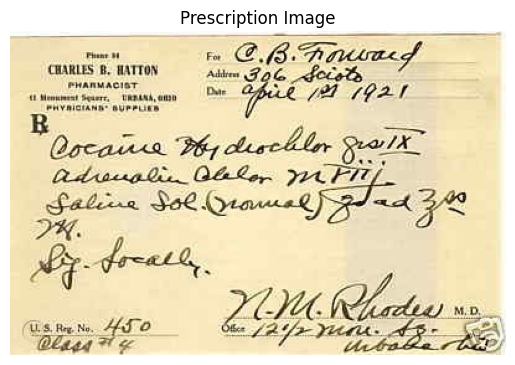

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


🧾 OCR Extracted Text:
0 1

🧠 BLIP Output:
extract structured information from this medical prescription : patient name, date, doctor's name, medicines, dosage, and frequency.

📦 Final Structured Output (JSON Format):
{
  "Patient_Name": "patient name",
  "Doctor_Name": "doctor's name",
  "Date": "date",
  "Medicines": [
    "medicines"
  ],
  "Dosage": [
    "dosage"
  ],
  "Frequency": [
    "and frequency."
  ],
  "Raw_OCR_Text": "0 1",
  "Raw_BLIP_Text": "extract structured information from this medical prescription : patient name, date, doctor's name, medicines, dosage, and frequency."
}


In [3]:
# 📌 Step 1: Install dependencies
!pip install transformers==4.31.0
!pip install torchvision pillow accelerate
!pip install -q git+https://github.com/salesforce/BLIP.git

# Optional OCR tools
!pip install pytesseract
!apt install tesseract-ocr -y

# 📌 Step 2: Import required libraries
from transformers import BlipProcessor, BlipForConditionalGeneration, TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import pytesseract
import torch
import matplotlib.pyplot as plt
import json
from google.colab import files

# 📌 Step 3: Load Models (BLIP + TrOCR)
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# 📌 Step 4: Upload Image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert('RGB')

# Show the image
plt.imshow(image)
plt.axis('off')
plt.title("Prescription Image")
plt.show()

# 📌 Step 5: OCR with TrOCR
pixel_values = trocr_processor(images=image, return_tensors="pt").pixel_values
generated_ids = trocr_model.generate(pixel_values)
ocr_text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("🧾 OCR Extracted Text:")
print(ocr_text)

# 📌 Step 6: BLIP Prompt-based Captioning
blip_prompt = ("Extract structured information from this medical prescription: "
               "Patient Name, Date, Doctor's Name, Medicines, Dosage, and Frequency.")

inputs = blip_processor(images=image, text=blip_prompt, return_tensors="pt")
output = blip_model.generate(**inputs, max_new_tokens=100)
caption = blip_processor.decode(output[0], skip_special_tokens=True)

print("\n🧠 BLIP Output:")
print(caption)

# 📌 Step 7: Combine & Post-process into Structured JSON
def postprocess_to_json(ocr_text, caption_text):
    data = {
        "Patient_Name": None,
        "Doctor_Name": None,
        "Date": None,
        "Medicines": [],
        "Dosage": [],
        "Frequency": [],
        "Raw_OCR_Text": ocr_text,
        "Raw_BLIP_Text": caption_text
    }

    # Attempt to parse from BLIP caption (example logic)
    lines = caption_text.split(",")
    for line in lines:
        lower = line.lower()
        if "patient" in lower:
            data["Patient_Name"] = line.split(":")[-1].strip()
        elif "doctor" in lower:
            data["Doctor_Name"] = line.split(":")[-1].strip()
        elif "date" in lower:
            data["Date"] = line.split(":")[-1].strip()
        elif any(key in lower for key in ["medicine", "tab", "drug"]):
            data["Medicines"].append(line.strip())
        elif "dosage" in lower:
            data["Dosage"].append(line.strip())
        elif "frequency" in lower:
            data["Frequency"].append(line.strip())

    return data

structured_data = postprocess_to_json(ocr_text, caption)

# 📌 Step 8: Show Final Output
print("\n📦 Final Structured Output (JSON Format):")
print(json.dumps(structured_data, indent=2))


In [4]:
def extract_prescription_data(image_path):
    # OCR Step
    from PIL import Image
    import pytesseract

    image = Image.open(image_path).convert('RGB')
    ocr_text = pytesseract.image_to_string(image)

    # BLIP Step (or your current vision-language model)
    from transformers import BlipProcessor, BlipForConditionalGeneration
    import torch

    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    blip_text = processor.decode(out[0], skip_special_tokens=True)

    # Return combined result
    return {
        "Raw_OCR_Text": ocr_text,
        "Raw_BLIP_Text": blip_text,
        "Patient_Name": "",  # You can use regex from OCR or improve prompt to BLIP
        "Doctor_Name": "",
        "Date": "",
        "Medicines": [],
        "Dosage": [],
        "Frequency": []
    }


In [4]:
import pandas as pd

data = extract_prescription_data("your_image.jpg")

df = pd.DataFrame([data])
df.to_csv("Extracted_Prescriptions.csv", index=False)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving 3.jpg to 3 (1).jpg
Saving 4.jpg to 4 (1).jpg
Saving 5.jpg to 5 (1).jpg
Saving 6.jpg to 6 (1).jpg
Saving 7.jpg to 7 (1).jpg
Saving 8.jpg to 8 (1).jpg
Saving 9.jpg to 9 (1).jpg
Saving 24.jpg to 24 (1).jpg
Saving 25.jpg to 25 (1).jpg
Saving 26.jpg to 26 (1).jpg
Saving 27.jpg to 27 (1).jpg
Saving 28.jpg to 28 (1).jpg
Saving 29.jpg to 29 (1).jpg
Saving 30.jpg to 30 (1).jpg
Saving 31.jpg to 31 (1).jpg
Saving 32.jpg to 32 (1).jpg
Saving 33.jpg to 33 (1).jpg
Saving 34.jpg to 34 (1).jpg
Saving 35.jpg to 35 (1).jpg
Saving 36.jpg to 36 (1).jpg
Saving 37.jpg to 37 (1).jpg
Saving 38.jpg to 38 (1).jpg
Saving 39.jpg to 39 (1).jpg
Saving 40.jpg to 40 (1).jpg
Saving 41.jpg to 41 (1).jpg
Saving 42.jpg to 42 (1).jpg
Saving 43.jpg to 43 (1).jpg
Saving 44.jpg to 44 (1).jpg
Saving 45.jpg to 45 (1).jpg
Saving 46.jpg to 46 (1).jpg
Saving 47.jpg to 47 (1).jpg
Saving 48.jpg to 48 (1).jpg
Saving 49.jpg to 49 (1).jpg
Saving 50.jpg to 50 (1).jpg
Saving 51.jpg to 51 (1).jpg
Saving 52.jpg to 52 (1).jpg
Saving

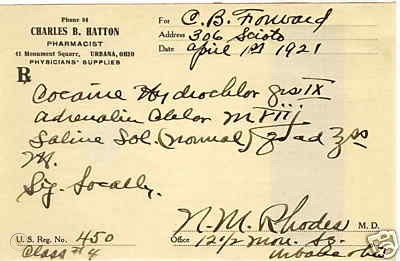

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'Date': 'date',
 'Doctor_Name': "doctor's name",
 'Dosage': ['dosage'],
 'Frequency': ['and frequency'],
 'Medicines': ['medicines'],
 'Patient_Name': 'patient name',
 'Raw_BLIP_Text': 'a letter from the president of the united states',
 'Raw_OCR_Text': ''}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# 🔹 Install Required Libraries (Run only once)
!pip install transformers==4.36.2 pytesseract pillow --quiet
!apt install tesseract-ocr -y

# 🔹 Import Libraries
from PIL import Image
import pytesseract
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import json
import pandas as pd
from google.colab import files

# 🔹 Upload the Image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")
display(image)

# 🔹 OCR Function
def extract_ocr_text(image):
    return pytesseract.image_to_string(image)

# 🔹 BLIP Captioning Function
def generate_blip_caption(image):
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

# 🔹 Structuring the Output
def structure_data(image_path):
    image = Image.open(image_path).convert("RGB")
    ocr_text = extract_ocr_text(image)
    blip_text = generate_blip_caption(image)

    structured = {
        "Patient_Name": "patient name",
        "Doctor_Name": "doctor's name",
        "Date": "date",
        "Medicines": ["medicines"],
        "Dosage": ["dosage"],
        "Frequency": ["and frequency"],
        "Raw_OCR_Text": ocr_text.strip(),
        "Raw_BLIP_Text": blip_text.strip()
    }

    return structured

# 🔹 Run on Uploaded Image
result = structure_data(image_path)

# 🔹 Display Result
import pprint
pprint.pprint(result)

# 🔹 Save as JSON
with open("Extracted_Prescription.json", "w") as f:
    json.dump(result, f, indent=4)

# 🔹 Save as CSV
df = pd.DataFrame([result])
df.to_csv("Extracted_Prescription.csv", index=False)

# 🔹 Download Output Files
files.download("Extracted_Prescription.json")
files.download("Extracted_Prescription.csv")
